## Group Request Evaluation

In [21]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

def read_playbacklog(csv_path, simId, clientId) :
    playfilename = csv_path + "playback_sim" + str(simId) +"_cl" + str(clientId) + ".csv"
    return pd.read_csv(playfilename, sep="\t")

def show_multiview_play(df_play) :
    nSegments = df_play.shape[0]
    print(df_play.head())

    # Get quality------------------------
    vp_q=df_play.iloc[:,4:]
    vp_i=df_play["vp"]
    Q = []
    j=0
    for i in vp_i:
        Q.append(vp_q.iloc[j][i])
        j+=1
    Q=np.array(Q)

    # Get Priority------------------------
    vp_high = ((df_play.iloc[:,4:] > 0)* [1,2,3,4,5]).T.max().astype(int)

    x=np.arange(0,nSegments,1)
    fig,ax = plt.subplots(figsize=(10, 4))
    ax2 = ax.twinx()
    ax.plot(x, df_play.vp+1, 'r*-', label='viewpoint change')
    ax.plot(x, vp_high, 'bx:',  label='Download priority')
    ax2.plot(x, Q,  'g.-',  label='playing Quality')
    ax.legend(loc='upper left')
    ax2.set_ylim([0, 6])
    ax.set_ylim([0, 6])
    
    ax.set_ylabel("Viewpoint")
    ax2.legend()
    ax2.set_ylabel("Quality")
    ax.set_xlabel("Segment Idx")
    ax.autoscale_view()
    plt.xticks(x)
    plt.savefig('groupresults.pdf')  
    plt.show()
    return


# ==================================================
csv_path = '../ns-3-allinone/ns-3.35/contrib/etri_mvdash/'
simId = 0
clientId = 0


### Adaptive

- Delayed priority update

   tIndex  vp    Start  Buffering?    q_v1    q_v2    q_v3    q_v4    q_v5
0       0   0   407898           0       0       0       0       0       0
1       1   0  2407898           0       0       0       0       0       0
2       2   0  4407898           0       1       0       0       0       0
3       3   0  6407898           0       3       0       0       0       0
4       4   2  8407898           0       3       0       0       0       0


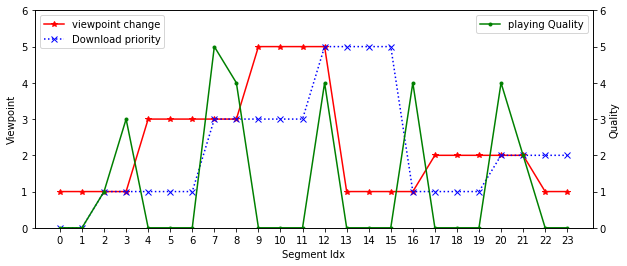

In [27]:
df_play = read_playbacklog(csv_path, simId, clientId)
show_multiview_play(df_play)

### Static Low Quality=2

- The algorithm fill up the buffer fast, 9 segment with vp 1 already downloaded
- At segment 4 VP is changed, but update priority at segment 10
- Resulted Long Delay

   tIndex  vp    Start  Buffering?    q_v1    q_v2    q_v3    q_v4    q_v5
0       0   0   407898           0       0       0       0       0       0
1       1   0  2407898           0       2       0       0       0       0
2       2   0  4407898           0       2       0       0       0       0
3       3   0  6407898           0       2       0       0       0       0
4       4   2  8407898           0       2       0       0       0       0


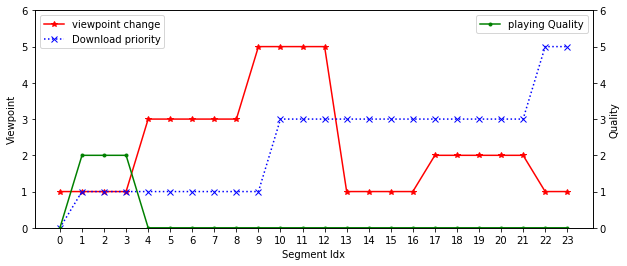

In [24]:
df_play = read_playbacklog(csv_path, simId, clientId)
show_multiview_play(df_play)

### Static Medium Quality=5

- It shows that the delay reduced when download quality=5
- Playback freezing occurs
- time is up


   tIndex  vp     Start  Buffering?    q_v1    q_v2    q_v3    q_v4    q_v5
0       0   0    407898           0       0       0       0       0       0
1       1   0   4042057           1       5       0       0       0       0
2       2   0  10606878           1       5       0       0       0       0
3       3   0  18197891           1       5       0       0       0       0
4       4   2  23362779           1       5       0       0       0       0


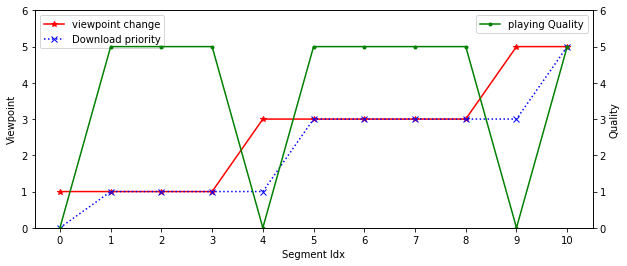

In [28]:
df_play = read_playbacklog(csv_path, simId, clientId)
show_multiview_play(df_play)

### Summary

   
    Q1. When it update viewpoint?
        --> During playback --> change directly
        --> But the update is delayed for the undownload segment

    Q2. Why the delay is long?
        --> Depend on rate selection
        --> Low Rate = fast fill ==> long delay
        --> Need proper rate adaptation

Current Adaptation strategy : 

1. It play based on the downloaded segment :
     - too fast filling (low rate) --> delay to play the appropriate segment
     - too slow (higher rate) --> delay reduce but cannot play all segment due to times up

Strategy to reduce delay : 

1. Number of Buffer
     * Single or multi doesn't matter : rate selection should depend on buffer occupancy and BW

2. Group vs Serial transmission 
     * Group
          * Direct VP change is possible
          * But with lower quality
          * Long delay
          
     * Serial
          * Focus on current view first when enough download other segment
          * Benefit : High quality for current view
          * Drawback : Delay for other view  

     --> try to apply serial



## Hybrid Evaluation

- This method combine both group request and single request

    tIndex  vp     Start  Buffering?    q_v1    q_v2    q_v3    q_v4    q_v5
0        0   0    407898           0       0       0       0       0       0
1        1   0   2407898           0       0       0       0       0       0
2        2   0   4407898           0       1       0       0       0       0
3        3   0   6407898           0       3       0       0       0       0
4        4   2   8407898           0       3       0       0       0       0
5        5   2  10407898           0       3       0       2       0       0
6        6   2  12407898           0       4       0       4       0       0
7        7   2  14407898           0       0       0       2       0       0
8        8   2  16407898           0       0       0       5       0       0
9        9   4  18407898           0       0       0       4       0       0
10      10   4  20407898           0       0       0       4       0       2
11      11   4  22407898           0       0       0       0       0       3

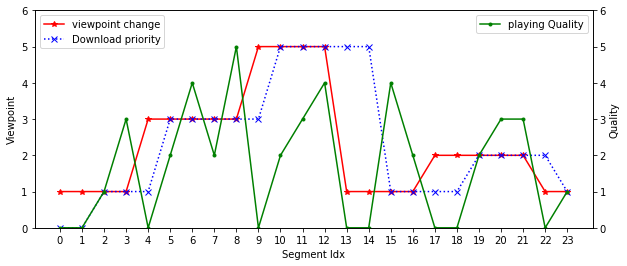

In [30]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

def read_playbacklog(csv_path, simId, clientId) :
    playfilename = csv_path + "playback_sim" + str(simId) +"_cl" + str(clientId) + ".csv"
    return pd.read_csv(playfilename, sep="\t")

def show_multiview_play(df_play) :
    nSegments = df_play.shape[0]
    print(df_play)

    # Get quality------------------------
    vp_q=df_play.iloc[:,4:]
    vp_i=df_play["vp"]
    Q = []
    j=0
    for i in vp_i:
        Q.append(vp_q.iloc[j][i])
        j+=1
    Q=np.array(Q)

    # Get Priority------------------------
    P = []
    j=0
    prev=0
    for i in vp_i:
        if (vp_q.iloc[j][i]==0):
            P.append(prev)
        else:
            P.append(i+1)
            prev=i+1
        j+=1
    vp_high=np.array(P)
    
    # vp_high = ((df_play.iloc[:,4:] > 0)* [1,2,3,4,5]).T.max().astype(int)

    x=np.arange(0,nSegments,1)
    fig,ax = plt.subplots(figsize=(10, 4))
    ax2 = ax.twinx()
    ax.plot(x, df_play.vp+1, 'r*-', label='viewpoint change')
    ax.plot(x, vp_high, 'bx:',  label='Download priority')
    ax2.plot(x, Q,  'g.-',  label='playing Quality')
    ax.legend(loc='upper left')
    ax2.set_ylim([0, 6])
    ax.set_ylim([0, 6])
    
    ax.set_ylabel("Viewpoint")
    ax2.legend()
    ax2.set_ylabel("Quality")
    ax.set_xlabel("Segment Idx")
    ax.autoscale_view()
    plt.xticks(x)
    plt.savefig('groupresults.pdf')  
    plt.show()
    return


# ==================================================
csv_path = '../ns-3-allinone/ns-3.35/contrib/etri_mvdash/'
simId = 0
clientId = 0

df_play = read_playbacklog(csv_path, simId, clientId)
show_multiview_play(df_play)